In [71]:
import numpy as np

from DORR_matrix import dorr

import matplotlib.pyplot as plt
import pennylane as qml

qml.QubitStateVector = qml.StatePrep

from device_var_lse_solver import DeviceVarLSESolver
from device import Device
from device import DeviceType
from qiskit_aer import AerSimulator


"""
To run this script you need the following packages:
- PennyLane (but the latest version does not have the QubitStateVector class (which is needed), so we redefine it above)
- Numpy < 2: need to install something like numpy 1.26.4
- Python 3.12
- torch 2.2.2
"""

'\nTo run this script you need the following packages:\n- PennyLane (but the latest version does not have the QubitStateVector class (which is needed), so we redefine it above)\n- Numpy < 2: need to install something like numpy 1.26.4\n- Python 3.12\n- torch 2.2.2\n'

In [186]:
qubits = 4
n = 2**(qubits)
alpha_list = [1.0, 0.1, 0.05, 0.01]

for ALPHA in alpha_list:
    A = dorr(ALPHA, n=n)
    cond = np.linalg.cond(A)
    print(f"alpha = {ALPHA:.1e} -> condition number = {cond:.6e}")

b = np.ones(n)
b = b / np.linalg.norm(b)

device = Device(DeviceType.QISKIT_AER, qubits=qubits)

alpha = 1.0e+00 -> condition number = 1.225201e+02
alpha = 1.0e-01 -> condition number = 1.990315e+02
alpha = 5.0e-02 -> condition number = 3.540236e+02
alpha = 1.0e-02 -> condition number = 2.016272e+04


In [187]:
# As defined by [10]
def TRC_ASA(iteration_count : dict):
    trc = 0
    max_size = max(iteration_count)
    for d in iteration_count:
        z = iteration_count.get(d)
        trc += z*max_size
    print(max_size)
    return trc

def generate_tridiagonal(n, alpha=2.0):
    """
    Generate a symmetric tridiagonal matrix of size n x n:
    Main diagonal = alpha
    Off-diagonals = -1

    alpha > 2 gives better conditioning.
    alpha ~ 2 is like the Laplacian (moderate conditioning).
    alpha < 2 becomes ill-conditioned.
    """
    A = np.diag(alpha * np.ones(n))
    A += np.diag(-1 * np.ones(n - 1), k=1)
    A += np.diag(-1 * np.ones(n - 1), k=-1)
    return A


In [198]:
alpha_list = [100.0, 10.0, 1.5]#, 1.5, 1.01]
for alpha in alpha_list:
    A = generate_tridiagonal(n=n, alpha=alpha)
    cond = np.linalg.cond(A)
    print(f"alpha = {alpha:.2f} → condition number = {cond:.2e}")



alpha = 100.00 → condition number = 1.04e+00
alpha = 10.00 → condition number = 1.49e+00
alpha = 1.50 → condition number = 1.58e+02


In [199]:
save = True
redo_calc = 2

local = False
lr = 0.001
threshold = 0.0001
steps = 10000
epochs = 10
abort = 200

results_list = np.zeros([redo_calc, len(b)])
TRC_list = np.zeros(redo_calc)



for ALPHA in alpha_list:
    for i in range(redo_calc):
        print(f"Run nr. {i+1}/{redo_calc}")
        A = generate_tridiagonal(n=n, alpha=ALPHA)
        local = True

        lse_dyn = DeviceVarLSESolver(A, 
                    b, 
                    method="direct", 
                    local=local, 
                    lr=lr, 
                    threshold=threshold,
                    steps=steps,
                    epochs=epochs, 
                    device=device) 

        solution_local, param_local, it_count_local = lse_dyn.solve()
        local_dense_trc = TRC_ASA(it_count_local)

        results_list[i, :] = solution_local
        TRC_list[i] = local_dense_trc


    

    if save == True:
        filename = f"data/result_local_condnr_{ALPHA}.npz"
        save_dict = {
            'A': A,
            'b': b,
            'results_list': results_list,
            'TRC_list': TRC_list,
            'nr_runs': redo_calc,
            'ALPHA': ALPHA,
            'qubits': qubits,

        }
        np.savez(filename, **save_dict)
        print(f"Saved {filename}")

Run nr. 1/2
Epoch 1/10:  33%|███▎      | 3266/10000 [00:12<00:26, 255.72it/s, best loss=0.000101, last improvement in step=3277, loss=0.0001]  
Loss of 0.0000995314 below stopping threshold.
Returning solution.
1
Run nr. 2/2
Epoch 1/10:  32%|███▏      | 3246/10000 [00:12<00:26, 252.85it/s, best loss=0.000105, last improvement in step=3254, loss=0.0001]  
Loss of 0.0000996762 below stopping threshold.
Returning solution.
1
Saved data/result_local_condnr_100.0.npz
Run nr. 1/2
Epoch 1/10:  43%|████▎     | 4279/10000 [00:17<00:23, 240.81it/s, best loss=0.000949, last improvement in step=3782, loss=0.000945]
Loss has not improved in last 500 steps.
Increasing circuit depth.
Epoch 2/10:  62%|██████▏   | 6188/10000 [00:49<00:30, 124.76it/s, best loss=0.000486, last improvement in step=5690, loss=0.000483]
Loss has not improved in last 500 steps.
Increasing circuit depth.
Epoch 3/10:  36%|███▋      | 3644/10000 [00:42<01:14, 85.40it/s, best loss=0.000566, last improvement in step=3150, loss=0.

In [200]:
mean_results = np.zeros([len(alpha_list), n])
std_results = np.zeros([len(alpha_list), n])
mean_trc = np.zeros(len(alpha_list))
std_trc = np.zeros(len(alpha_list))

classical_solution = np.zeros([len(alpha_list), n])

for i, ALPHA in enumerate(alpha_list):

    filename = f"data/result_local_condnr_{ALPHA}.npz"
    data = np.load(filename)
    
    A = data['A']
    b = data['b']
    results_list = data['results_list']
    TRC_list = data['TRC_list']
    nr_runs = data['nr_runs']
    ALPHA = data['ALPHA']
    qubits = data['qubits'] 


    mean_results[i, :] = np.mean(results_list, axis=0)
    std_results[i, :] = np.std(results_list, axis=0)
    mean_trc[i] = np.mean(TRC_list)
    std_trc[i] = np.std(TRC_list)

    # compute normalized classical solution for comparison, therefore first re-compose system matrix A
    classic_sol = np.linalg.solve(A, b)
    normalized_classical_solution = np.square(classic_sol / np.linalg.norm(classic_sol))

    classical_solution[i, :] = normalized_classical_solution




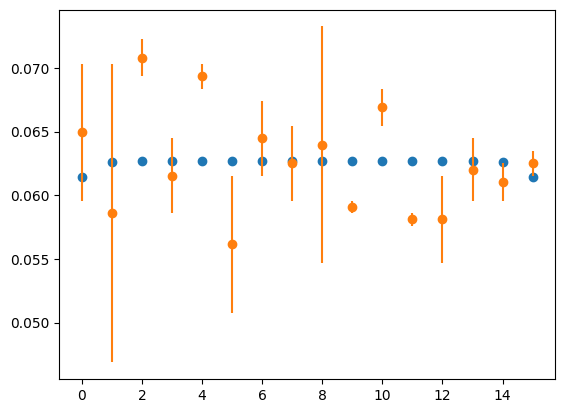

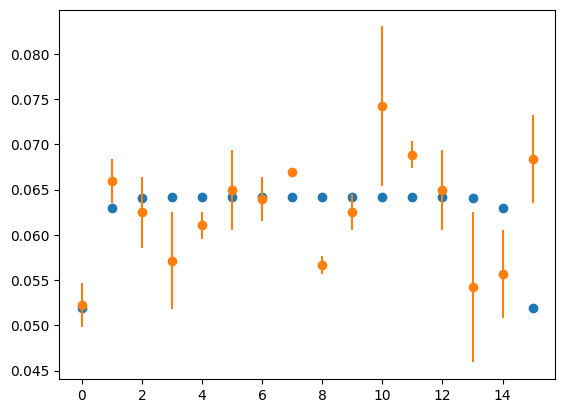

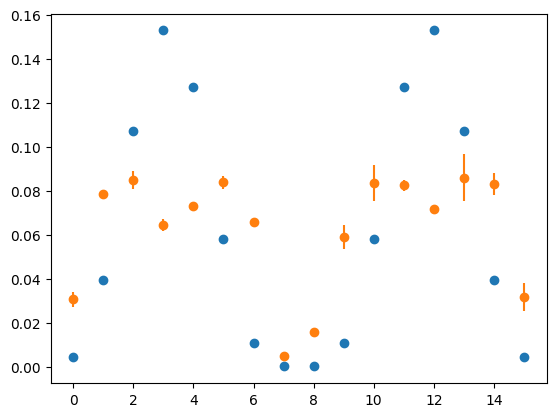

In [201]:
for i, ALPHA in enumerate(alpha_list):
    plt.figure()
    plt.plot(classical_solution[i, :], 'o')
    plt.errorbar(np.arange(n), mean_results[i, :], yerr=std_results[i, :], fmt='o')

    plt.show()